#### Importing Libraires

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler

#### Getting the files

In [2]:
INPUT_CSV = r'/Users/vanshikasharma/Desktop/Advanced ML/working_file_with_street_names.csv' 
OUTPUT_CSV = r'/Users/vanshikasharma/Desktop/Advanced ML/congestion_with_labels.csv'
USE_MINIBATCH = True          
RANDOM_STATE = 42
K_FINAL = 3                   #We want Low/Medium/High
K_GRID = range(2, 7)      
SIL_SAMPLE_N = 3000           
FEATURE_COLS = ["Sum_Volume", "Avg_Volume", "Hour"]           
PLOT_SILHOUETTE = True       

### Loading the file

In [3]:
df = pd.read_csv(INPUT_CSV)
X = df[FEATURE_COLS].copy()

### Preprocessing pipeline for handling data cleaning and transforamtion.

In [4]:
preprocess = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("power", PowerTransformer(method="yeo-johnson", standardize=False)),
    ("scale", StandardScaler()),
])

X_trans = preprocess.fit_transform(X)

### Silhouette Anlaysis (Choosing K)

In [5]:
rng = np.random.default_rng(42)  
sample_size = min(3000, len(X_trans)) 
sample_rows = rng.choice(len(X_trans), size=sample_size, replace=False)
X_sample = X_trans[sample_rows] 

k_values = range(2, 7)  
scores = {}  

for k in k_values:
    print(f"Testing {k} clusters...")
    if USE_MINIBATCH:
        model = MiniBatchKMeans(n_clusters=k, random_state=42)
    else:
        model = KMeans(n_clusters=k, random_state=42)

    labels = model.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    scores[k] = score
    print(f"Silhouette Score for k={k}: {score:.3f}")
best_k = max(scores, key=scores.get)

Testing 2 clusters...
Silhouette Score for k=2: 0.631
Testing 3 clusters...
Silhouette Score for k=3: 0.602
Testing 4 clusters...
Silhouette Score for k=4: 0.612
Testing 5 clusters...
Silhouette Score for k=5: 0.642
Testing 6 clusters...
Silhouette Score for k=6: 0.652


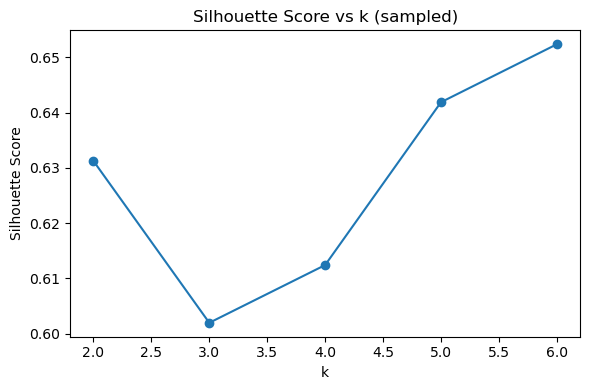

Best k by silhouette: 6


In [6]:
plt.figure(figsize=(6,4))
plt.plot(list(scores.keys()), list(scores.values()), marker="o")
plt.title("Silhouette Score vs k (sampled)")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()
print("Best k by silhouette:", best_k)

In [7]:
print('Silhouette (sampled)')
for k in k_values:
    print(f"k={k}: silhouette={scores[k]:.4f}")
print(f"Best k by silhouette (sampled): {best_k} (score={scores[best_k]:.4f})")

Silhouette (sampled)
k=2: silhouette=0.6313
k=3: silhouette=0.6020
k=4: silhouette=0.6124
k=5: silhouette=0.6419
k=6: silhouette=0.6524
Best k by silhouette (sampled): 6 (score=0.6524)


### Final Clsutering and Congestion Level Labelling

In [8]:
from sklearn.cluster import KMeans, MiniBatchKMeans

if USE_MINIBATCH:
    model = MiniBatchKMeans(n_clusters=K_FINAL, random_state=42)
else:
    model = KMeans(n_clusters=K_FINAL, random_state=42)


labels = model.fit_predict(X_trans)

In [9]:
sil_final = silhouette_score(X_sample, model.predict(X_sample))
print(f"Final model k={K_FINAL}: silhouette (sampled) = {sil_final:.4f}")


Final model k=3: silhouette (sampled) = 0.6115


In [10]:
cluster_means = (
    pd.DataFrame({
        "cluster": labels,
        "Sum_Volume": X["Sum_Volume"].values,
        "Avg_Volume": X["Avg_Volume"].values,
    })
    .groupby("cluster")[["Sum_Volume", "Avg_Volume"]]
    .mean()
    .reset_index()
)

cluster_means_sorted = cluster_means.sort_values(by=["Sum_Volume", "Avg_Volume"]).reset_index(drop=True)
rank_to_label = {0: "Low", 1: "Medium", 2: "High"}

# Map actual cluster id -> rank
cluster_id_to_rank = {}
for rank, row in cluster_means_sorted.reset_index().iterrows():
    cluster_id_to_rank[int(row["cluster"])] = rank

congestion_level = [rank_to_label[cluster_id_to_rank[c]] for c in labels]

In [11]:
out = df.copy()
out["cluster_id"] = labels
out["Congestion_Level"] = congestion_level

In [12]:
bias_cols = ["Region", "DayOfWeek"]
for col in bias_cols:
    if col in out.columns:
        print(f"\n=== {col} vs Congestion_Level ===")
        # Make a simple percentage table
        table = pd.crosstab(out[col], out["Congestion_Level"], normalize="index") * 100
        print(table.round(1))


=== Region vs Congestion_Level ===
Congestion_Level  High   Low  Medium
Region                              
NCITY             33.4  21.9    44.7
SCITY             23.7  26.1    50.2

=== DayOfWeek vs Congestion_Level ===
Congestion_Level  High   Low  Medium
DayOfWeek                           
Friday            27.8  35.6    36.7
Monday            28.8  12.1    59.1
Saturday          31.3  49.3    19.4
Sunday            25.9  39.9    34.2
Thursday          26.0  15.6    58.3
Tuesday           27.5   8.5    64.0
Wednesday         30.6  19.3    50.1


In [13]:
dist = out["Congestion_Level"].value_counts()
print("\nCluster size distribution:")
print(dist)


Cluster size distribution:
Congestion_Level
Medium    28582
High      16952
Low       14491
Name: count, dtype: int64


In [14]:
out.to_csv(OUTPUT_CSV, index=False)
print(f"Saved labeled dataset to: {OUTPUT_CSV}")

Saved labeled dataset to: /Users/vanshikasharma/Desktop/Advanced ML/congestion_with_labels.csv
